## Welcome to E-tivity 2

Your Name: Zheng Hanming

Your Student ID Number: 21225621

### Objective:
*Adapt and implement two techniques for pricing European and American Call and Put options and, for the latter technique,
calculate the cost of setting up a tailored option portfolio such that we can benefit from expectations of high volatility.*

### Background Information
This weeks' set of videos focused primarily on stock option contracts. We detailed in **Lecture 5** the various **payoffs,
profits, and losses** that can be garnered by participating in option trading.

We also saw how differing option positions
can be chained together to create an **option portfolio** that can cater to a multitude of risk and cost appetites.

In **Lecture 7** we met two methods of pricing options: the Binomial Tree Pricing method (suitable for pricing all options)
and the Black-Scholes-Merton pricing method (suitable for pricing all options except for the American Put). Both methods
are reasonably accurate in pricing options, so long as we are provided with current market information, and the underlying stock does not pay dividends.

In E-tivity 2, your task is to implement these models in Python, and create an option portfolio using the Black-Scholes-Merton
model that can adequately replicate the set-up costs of a **Reverse Iron Butterfly Spread**.


**Note that all percentage inputs for these tasks must be provided in decimal form.**

## 1. Library Requirements

In [155]:
#!pip install -U setuptools
#!pip install numpy matplotlib stats

In [156]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

No external data is required for this e-tivity, so we can skip straight on to:

## 2. E-tivity Actions

#### Objective
*Implement an n-step Binomial Tree pricing model and a Black-Scholes-Merton pricing model, and calculate the cost (or
 upfront gain) of setting up a Reverse Iron Butterfly Spread using prices derived from the Black-Scholes-Merton pricing model.*

### Task Breakdowns:
####    Task 1: N-Step Binomial Tree
1. Derive $u$, $d$, and $p$.
2. Find all future possible asset prices in the tree by multiplying $S_0$ by combinations of powers $u^{n-x}$ and $d^x$.
3. Calculate the payoffs at the final step of the tree, since we know at this point that the option payoff = option price.
 *(Note that in this workbook, we calculate all payoffs at all nodes for all time steps, rather than all nodes at the final time step).*
4. Working your way back through the tree toward step $0$, calculate the probability-weighted discounted price of the
option at each step of the tree until you derive an initial option value..

Steps 2 - 4 are summarised below:

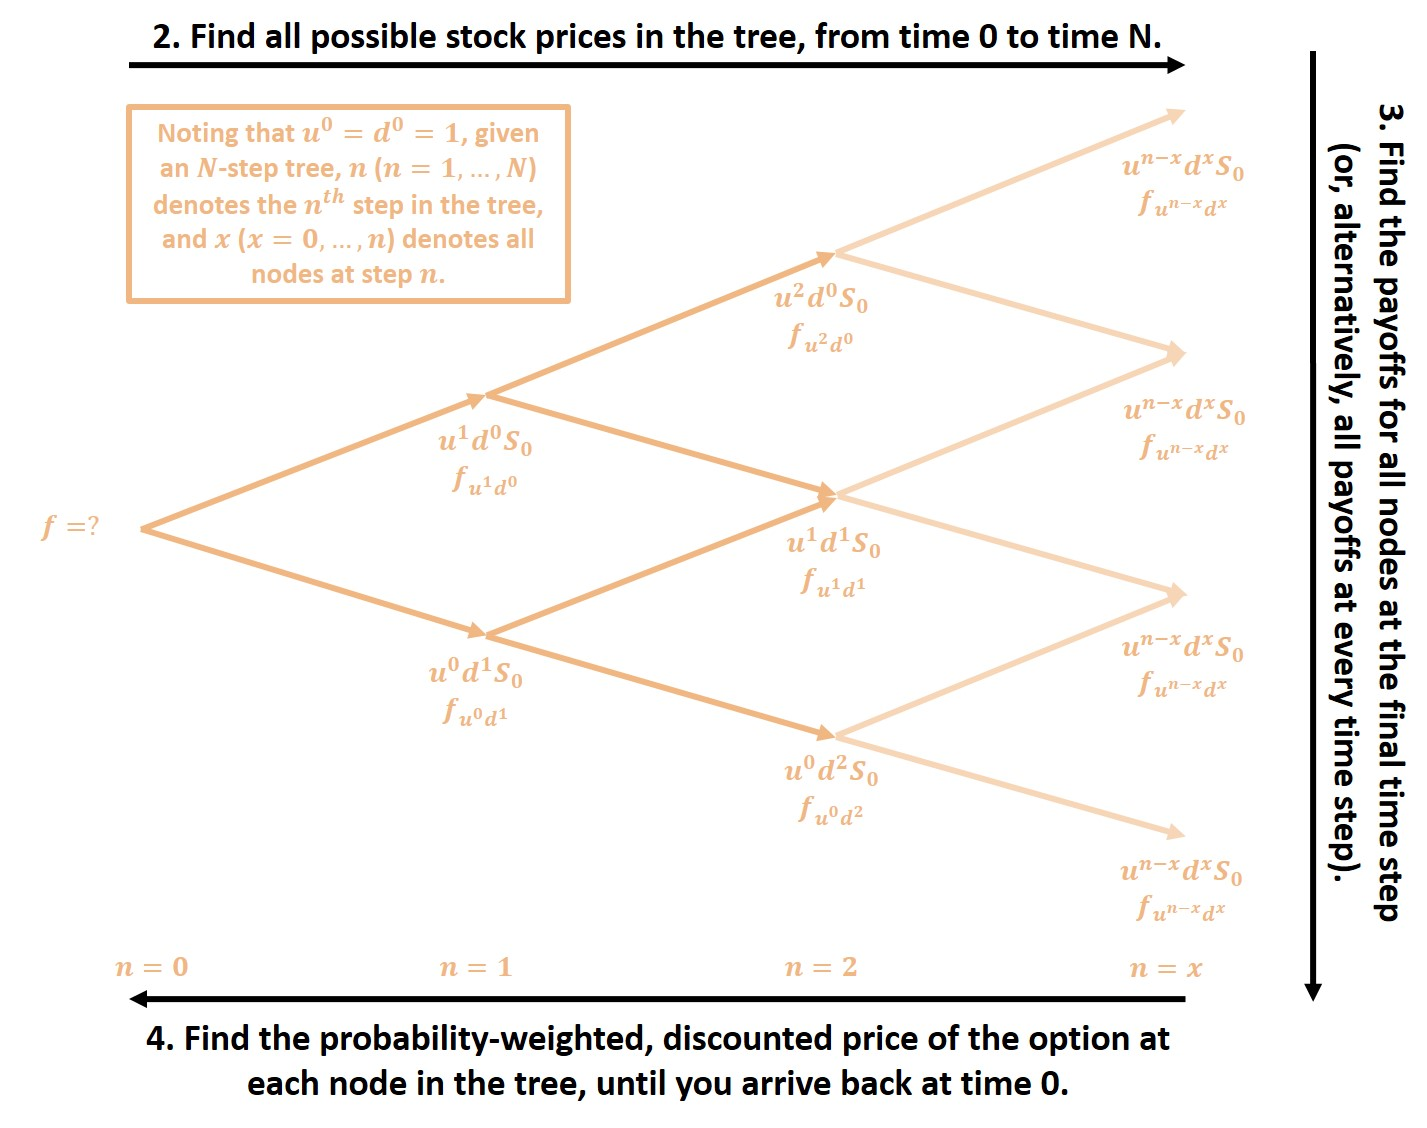

In [157]:
from IPython.display import Image
Image(filename ="n_step_Bin_Tree.jpg")

## Task 1: N-step Binomial Tree

#### Sub-task 1

Before being able to compute asset prices and option prices, we must form a reasonable view on how they vary up or down
at each time step, and the risk-neutral probability of an upward movement vs. a downward movement. $u$ is the multiplicative
factor tied to upward movements in the asset price, $d$ is the multiplicative factor tied to downward movements in the
asset price, and $p$ is the probability of an upward movement.

#### Objective
Derive $u$, $d$, and $p$.

#### Further details
Our implementation of the Binomial tree will be based on an 'empirical' view of expected asset price movements, rather
than based on a user-defined judgment of upward or downward movements. As such, we will be deriving $u$, $d$, and consequentially
$p$ on the basis of the approach outlined in Slide 9 of Lecture 7.

*Hint: use `np.exp(x)` to replicate the `e` computation seen in the Lecture 7 slides.*

In [158]:
# variable configuration
steps = 2
initial_price = 97.61
strike_price = 98
volatility = 0.4015
risk_free_rate = 0.0481
time_to_maturity = 24/252
time_increment = time_to_maturity/steps
option_type = 'call' # put | call
exercise_type = 'american' # american | european

In [159]:
"""
Passes in constant values representing the risk-free interest rate, the volatility of the underlying asset, and the space
of time between each price movement 'step'.

Parameters
---------
interest_rate : float
    The dataframe to pass in, that is populated with business days.
volatility : float
    Volatility of the underlying asset price movements
time_increment : float
    length of time between assumed asset price movements

Returns
-------
u : float
    multiplicative factor associated with an upward movement in the asset price, where u > 1.
d : float
    multiplicative factor associated with a downward movement in the asset price, where d < 1.
p : float
    risk-neutral probability of an upward movement
"""

def movement_vars(interest_rate, volatility, time_increment):

    ##** YOUR CODE STARTS HERE**
    risk_free_multiplier = np.exp(interest_rate * time_increment)
    u = np.exp(volatility * np.sqrt(time_increment))
    d = np.exp(-1 * volatility * np.sqrt(time_increment))
    p = (risk_free_multiplier - d) / (u - d)
    ##** YOUR CODE ENDS HERE**
    return u, d, p

In [160]:
##** YOUR CODE STARTS HERE**
u, d, p = movement_vars(risk_free_rate, volatility, time_increment)
print(u, d, p)
##** YOUR CODE ENDS HERE**

1.0915672231037195 0.9161139862340674 0.4911799670297163


#### Sub-task 2

To calculate the option value at all points in time, including at time 0, we must have information on the expected asset
price at all points in time. Sub-task 2 involves using the values derived for $u$, $d$, and $p$ in sub-task 1 to calculate
the expected asset price at all nodes in the Binomial Tree, beginning from time 0's `initial price`.

#### Objective
Compute the `asset price tree`, containing the expected asset price for all nodes in the N-step Binomial Tree.

#### Further details
Details of the computation are available in the image above, where you will be completing Step 2. You will be using 2 `for`
loops - one for the number of steps in the Tree, and another for the number of nodes at each time step. The first `for`
loop should be conceptually unproblematic as number of steps in the tree is fixed once initiated, but the second `for`
loop can be tricky to implement as the number of nodes at each time step increases by 1 each time step.

*Hint: set the upper limit on the second `for` loop to be the index on the first loop + 1. For example, if the first `for` loop
is `for i in...`, then the second for loop should have an upper limit of `i+1`.*

In [161]:
"""
Calculates the asset price tree for an N-step Binomial Tree model by multiplying the initial asset price with differing
combinations of u and d.

Parameters
---------
initial_price : float
    Initial asset price
up_multiplier : float
    multiplicative factor associated with an upward movement in the asset price, where u > 1.
down_multiplier : float
    multiplicative factor associated with a downward movement in the asset price, where d < 1.
steps : int
    Number of steps in the N-step tree (you met 1-step and 2-step trees in Lecture 7)

Returns
-------
future_prices : array
    An array containing the asset price tree, where [0,0] contains the initial asset price.
"""

def price_tree(initial_price, up_multiplier, down_multiplier, steps):

    future_prices = np.zeros((steps+1, steps+1))

    ##** YOUR CODE STARTS HERE **
    # calculate the future stock prices and put them into a table
    for i in range(steps + 1):
        # i is the col: 1st col is the original price | 2nd col is the prices at step 2 | 3rd col is the prices at step 3
        print(f'i={i}')
        for j in range(i + 1):
            # future prices are calculated using the formula: init_price x up_muliplier^up_power x down_multiplier^down_power
            # up_power & down_power are generated using the i and j variables in the loops
            # refer to the print statements for illustration on how the up_power & down_power changes for each row and col
            u_pow = i-j
            d_pow = j
            future_prices[j, i] = initial_price * up_multiplier**u_pow * down_multiplier**d_pow
            print(f'  j={j}: ', f'{initial_price} x u^{u_pow} x d^{d_pow} = {round(future_prices[j, i], 4)}')
    ##** YOUR CODE ENDS HERE **
    return future_prices

In [162]:
##** YOUR CODE STARTS HERE **
prices = price_tree(initial_price, u, d, steps)
print('')
print('=======Price Tree=======')
print(prices)
##** YOUR CODE ENDS HERE **


i=0
  j=0:  97.61 x u^0 x d^0 = 97.61
i=1
  j=0:  97.61 x u^1 x d^0 = 106.5479
  j=1:  97.61 x u^0 x d^1 = 89.4219
i=2
  j=0:  97.61 x u^2 x d^0 = 116.3042
  j=1:  97.61 x u^1 x d^1 = 97.61
  j=2:  97.61 x u^0 x d^2 = 81.9206

=======Price Tree=======
[[ 97.61       106.54787665 116.30416984]
 [  0.          89.4218862   97.61      ]
 [  0.           0.          81.92064062]]


#### Sub-task 3

The N-Step Binomial Tree calculator being implemented in this workbook can value both American and European options.
European options can only be exercised at the time of the contract's expiry, whereas American options can be exercised at
any moment until expiry. If an option's payoff at a node exceed it's risk-neutral valuation at that point, the logical move
would be to exercise the option at that point. Hence, we need to be aware of the prevailing payoff of an option at all
points in the tree, not just at the final time step.

#### Objective
Compute the `option payoff tree`, containing the payoff at all nodes in the N-step Binomial Tree, assuming the option was
to be exercised at that point.

#### Further details
Reminder that the intrinsic value for a call is $max[S_t - K, 0]$ and a payoff for a put is $max[K-S_t,0]$, for $0 \leq t \leq T$.

*Hint: No `for` loop is needed for this sub-task as we will be using the result of the array calculated in sub-task 2 as the representation
for $S_t$. All that is required in sub-task 3 is computing the inner-bracket calculation for a payoff of an option, and
thereafter setting all negative elements to 0.*

In [163]:
"""
Calculates the option payoff tree for an N-step Binomial Tree model using the previously-computed asset price tree and
constant strike.

Parameters
---------
option_type : string
    whether the option is a call ("call", "Call") or a put ("put", "Put").
tree_prices : array
    asset price tree array computed in sub-task 2.
strike : float
    strike serving as a basis for calculating the payoff for all nodes in the tree.

Returns
-------
future_payoffs : array
    An array (with the same shape as the asset price tree) containing the option payoff tree, where [0,0] contains the time 0 payoff.
"""

def payoff_tree(option_type, tree_prices, strike):

    future_payoffs = np.zeros(np.shape(tree_prices))

    if option_type == "call" or option_type == "Call":
        ##**YOUR CODE STARTS HERE**
        # use np.subtract to perform subtraction on array against a scalar number(strike)
        # price - strike because call will be exercised when price is above strike
        future_payoffs = np.subtract(tree_prices, strike)
        ##**YOUR CODE ENDS HERE**
    elif option_type == "put" or option_type == "Put":
        ##**YOUR CODE STARTS HERE**
        # use np.subtract to perform subtraction on array against a scalar number(strike)
        # strike - price because put will be exercised when price below above strike
        future_payoffs = np.subtract(strike, tree_prices)
        ##**YOUR CODE ENDS HERE**
    else:
        print("please enter either 'call' or 'put'.")

    # setting negative values and payoffs that are == strike to be 0
    ##**YOUR CODE STARTS HERE**
    future_payoffs[future_payoffs < 0] = 0
    future_payoffs[future_payoffs == strike] = 0
    ##**YOUR CODE STARTS HERE**

    return future_payoffs

In [164]:
##** YOUR CODE STARTS HERE**
payoffs = payoff_tree(option_type, prices, strike_price)
print('=======Payoff Tree=======')
print(payoffs)
##** YOUR CODE ENDS HERE**

=======Payoff Tree=======
[[ 0.          8.54787665 18.30416984]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]


#### Sub-task 4

Starting from the final step $N$, this function calculates the initial value of an option by working its back through
each step of the Binomial Tree until it reaches time 0.

#### Objective
Compute $f$, the initial value of the option.

#### Further details

Compute the risk-neutral value of the option at all nodes as per the details provided in Slide 8 of Lecture 7. Our first
basis for deriving the option value is at the final step of the tree, as this is the only time we know with certainty
the option value (since option payoff = option value at expiry). After that, we will continue to derive the option value
as being it's discounted, risk-neutral value at each point in the tree, with the following caveats:
- For European Options, the discounted risk-neutral valuation will apply at all nodes.
- For American Options, the value of the option at each node is max[payoff, discounted risk-neutral valuation].


*Hints:*
1. *'working backwards through the tree' means we are carrying out the same index trickery as in sub-task 2, just in reverse.
You may find the '`for __ in reversed(range(x)):`' function useful to count down, rather than up, an index.*
2. *Note that `discounted_option_price` has the same shape as `future_prices` in sub-task 2.*
3. *Since your calculations will be involving values from one step forward, the upper limit of the first `for` loop
index can be found using `len(discounted_option_price)-1`, and your calculation formula should include `[i+1]` and `[j+1]` as indices.*

In [165]:
"""
Calculates the option value of an American or European Call or Put using an N-step Binomial Tree model.

Parameters
---------
option_exercise_type : string
    whether the option has an American ("american", "American") or European ("european", "European") payoff structure.
tree_prices : array
    option payoff tree array computed in sub-task 3.
interest_rate : float
    risk-free interest rate
prob_up : float
    risk-neutral probability of an upward movement
time_increment : float
    length of time between asset price movements, stated in years.

Returns
-------
discounted_option_price[0,0] : float
    The first element of an array containing the option price at all nodes in the tree. The first element contains the
    time 0 option value.
"""

def option_price(option_exercise_type, tree_payoffs, interest_rate, prob_up, time_increment):
    if option_exercise_type not in ['american', 'european', 'American', 'European']:
        print("please enter 'american' or 'european' for 'option_exercise_type'")

    discounted_option_price = np.zeros(np.shape(tree_payoffs))
    discounted_option_price[:,-1] = tree_payoffs[:,-1]

    discount_factor = np.exp(-1 * interest_rate * time_increment)

    # calculate the discounted options prices and put them into a table(array of array)
    for i in reversed(range(len(discounted_option_price)-1)):
        # i is the col: the code goes from the last step back towards the first step.
        print(f'i={i}')
        for j in range(i + 1):
            # assume this step is time_x
            # f_u: option price of the scenario where price will go up at time_x + 1
            f_u = discounted_option_price[j, i+1]
            # f_d: option price of the scenario where price will go down at time_x + 1
            f_d = discounted_option_price[j+1,i+1]
            # discount_val: discounted option price using the below formula time_x
            discount_val = (prob_up * f_u + (1 - prob_up) * f_d) * discount_factor

            # below shows the difference between american and european option pricing logic
            if option_exercise_type == "american" or option_exercise_type == "American":
                # american option can be exericed at any time
                payoff_t = tree_payoffs[j,i]
                # option is the max of discounted and the current payoff at time_x because it can be exercised any time_x
                discounted_option_price[j, i] = max(discount_val, payoff_t)
            elif option_exercise_type == "european" or option_exercise_type == "European":
                # american option can be exericed at the end of option expiry
                discounted_option_price[j,i] = discount_val
            print(f'   j={j} f_u={round(f_u, 4)} f_d={round(f_d, 4)}  =>    {discounted_option_price[j, i]}')
            

    return discounted_option_price[0,0]

In [166]:
## ** YOUR CODE STARTS HERE **
option_p = option_price(exercise_type, payoffs, risk_free_rate, p, time_increment)
print(f'Option Price at T0: {option_p}')
## ** YOUR CODE ENDS HERE **

i=1
   j=0 f_u=18.3042 f_d=0.0  =>    8.970072253529954
   j=1 f_u=0.0 f_d=0.0  =>    0.0
i=0
   j=0 f_u=8.9701 f_d=0.0  =>    4.395839687886453
Option Price at T0: 4.395839687886453


Congratulations! You have now created an N-Step Binomial Tree Pricing model that can be used to value all Vanilla Options
(American and European Calls and Puts). You may find that as you increase the number of steps in your tree, your answer
will converge to that of the Black-Scholes-Pricing model, assuming that all of the relevant inputs are consistent across
both models.

Implementing the Black-Scholes-Pricing model is our next task, following which we will calculate the price (or upfront gain)
associated with constructing a Reverse Iron Butterfly Spread.

The steps to carry this out are as follows:

####    Task 2: Black-Scholes-Merton model
1. Calculate $d_1$ and $d_2$ and find their cumulative standard normal distribution values $N(d_1)$ and $N(d_2)$.
2. Calculate the option price using $N(d_1)$ and $N(d_2)$, along with the remaining derivative pricing inputs.
3. Calculate the cost of setting up an option portfolio, using the function created in step 2.

## Task 2: Black-Scholes-Pricing Model

#### Sub-task 1

The majority of the mathematical complexity in calculating option prices using the Black-Scholes-Merton model is in calculating
the values for $d_1$ and $d_2$, which in turn are fed into the cumulative standard normal distribution function $N(x)$.

$d_1$ and $d_2<0$ can be thought of as proxies for 'standardised moneyness', with 'at the money' level = 0. In this
analogy $d_1, d_2<0$ serve as out-of-the-money and in-the-money indicators for a call and put, respectively, while $d_1,
 d_2>0$ serve as in-the-money and out-of-the-money indicators for a call and put, respectively.

Pushing the emphasis on the 'practical' side a little further, $N(d_2)$ is the probability that an option will be exercised
in a risk-neutral world, while $N(d_1)$ represents how much an option price should change by based on a movement in the
underlying asset price.

#### Objective
Compute constant values $d_1$, $d_2$, $N(d_1)$, and $N(d_2)$.

#### Further details
The relevant equation(s) can be found in Slide 10 of Lecture 7.

*Hints:*

1. *use '`np.log(x)`' to compute ln(x). You may also benefit from using other `numpy` terms, namely `np.divide`,
`np.multiply`, `np.power`, and `np.sqrt`*.
2. *The cumulative standard normal distribution values for $d_1$ and $d_2$ can be found using `stats.norm(0,1).cdf(x)`*.
3. *Note that $N(-d_1) = 1-N(d_1)$, and $N(-d_2)=1-N(d_2)$, hence they do not need to be computed within the function.*

In [167]:
"""
Computes the cumulative standard normal distribution values for d1 and d2, given the initial asset price and volatility,
the option strike price, the risk-free interest rate, and the time to the maturity on the option.

Parameters
---------
initial_price : float
    Initial asset price
strike : float
    strike price of the option
volatility : float
    volatility of the underlying asset
rate : float
    risk-free interest rate
time_to_maturity : float
    length of time before option expires, in years.

Returns
-------
Nd1 : float
    cumulative standard normal value for d1
Nd2 : float
    cumulative standard normal value for d2
"""

def standard_normal_placement(initial_price, strike, volatility, rate, time_to_maturity):

    ## ** YOUR CODE STARTS HERE
    # calculate d1, d2, Nd1, Nd2 using the forumla below
    d1 = (np.log(initial_price / strike) + (risk_free_rate + np.power(volatility, 2) / 2) * time_to_maturity) / (volatility * np.sqrt(time_to_maturity))
    d2 = d1 - volatility * np.sqrt(time_to_maturity)
    Nd1 = stats.norm(0, 1).cdf(d1)
    Nd2 = stats.norm(0, 1).cdf(d2)
    ## ** YOUR CODE ENDS HERE
    return Nd1, Nd2

In [168]:
## ** YOUR CODE STARTS HERE
N_d1, N_d2 = standard_normal_placement(initial_price, strike_price, volatility, risk_free_rate, time_to_maturity)
## ** YOUR CODE ENDS HERE

#### Sub-task 2

Once the values for $N(d_1)$ and $N(d_2)$ have been computed, it is rather straightforward to calculate the Black-Scholes-Merton
option price.

#### Objective
Compute the Black-Scholes-Merton option price.

#### Further details
Based on the dates provided in the `daily_rates` dataframe, discern the number of calendar days between each successive
overnight rate, so that it's relative 'influence' in the compounding formula can be more accurately assessed.

*Hint: use `np.exp(x)` to replicate the `e` computation seen in the Lecture 7 slides. Don't forget that $N(-d_1) = 1-N(d_1)$, and $N(-d_2)=1-N(d_2)$.*

In [169]:
"""
Derives a value for European options and American calls using the Black-Scholes-Merton pricing formula.

Parameters
---------
option_type : string
    whether the option is a call ("call", "Call") or a put ("put", "Put").
initial_price : float
    Initial asset price
strike : float
    strike price of the option
volatility : float
    volatility of the underlying asset
rate : float
    risk-free interest rate
time_to_maturity : float
    length of time before option expires, in years.

Returns
-------
BSM_price : float
    option value according to the Black-Scholes-Merton pricing formula.
"""

def bsm_option_price(option_type, initial_price, strike, volatility, rate, time_to_maturity):

    ## ** YOUR CODE STARTS HERE
    Norm_d1, Norm_d2 = standard_normal_placement(initial_price, strike, volatility, rate, time_to_maturity)
    discounted_strike = strike * np.exp(-1 * risk_free_rate * time_to_maturity)
    ## ** YOUR CODE ENDS HERE

    if option_type == "call" or option_type == "Call":
        ## ** YOUR CODE STARTS HERE
        # calculate the option price using Black-Sholes-Merton formula for call option
        BSM_price = initial_price * Norm_d1 - discounted_strike * Norm_d2
        ## ** YOUR CODE ENDS HERE
    elif option_type == "put" or option_type == "Put":
        ## ** YOUR CODE STARTS HERE
        # calculate the option price using Black-Sholes-Merton formula for put option
        BSM_price = discounted_strike * (1 - Norm_d2) - initial_price * (1 - Norm_d1)
        ## ** YOUR CODE ENDS HERE
    else:
        print("please enter either 'call' or 'put'")

    return BSM_price

In [170]:
## ** YOUR CODE STARTS HERE
call_price = bsm_option_price(option_type, initial_price, strike_price, volatility, risk_free_rate, time_to_maturity)
print(call_price)
## ** YOUR CODE ENDS HERE

4.849470873438619


#### Final sub-task

Calculate the cost / upfront gain associated with entering into a **Reverse Butterfly Spread**, given the following parameters:
   - $S_0 = 8,000$
   - $K_1 = 7,800$
   - $K_2 = 8,000$
   - $K_3 = 8,200$
   - $\sigma = 15%$
   - $r = 2.5\%$
   - $T = \frac{1}{2}$

*Note:*
1. *If you are selling a call, this represents a positive income upfront, and if you are buying a call, this represents a negative cost upfront.*
2. *If a position is not used, replaced it with `0`.*

In [171]:
## ** YOUR CODE STARTS HERE
position_1 = bsm_option_price('call', 8000, 7800, 0.15, 0.025, 0.5)
position_2 = bsm_option_price('call', 8000, 8000, 0.15, 0.025, 0.5)
position_3 = bsm_option_price('call', 8000, 8200, 0.15, 0.025, 0.5)
position_4 = 0 # bsm_option_price(                                  )
position_5 = 0 # bsm_option_price(                                  )
position_6 = 0 # bsm_option_price(                                  )

# reversed butterfly spread consists of Short Call K_1 + 2 x Long Call K_2 + Short Call K_3
Reverse_Butterfly_Spread = position_1 - 2 * position_2 + position_3
print(position_1, position_2, position_3, Reverse_Butterfly_Spread)
## ** YOUR CODE ENDS HERE

557.9759376265029 437.9368721756382 335.8988189765314 18.001012251757857


And that's it! You have implemented a Black-Scholes-Merton pricing model, and put together an initial expected cost for
the upfront P&L associated with setting up a tailored option portfolio.


### Extra Content: Plotting the Profit and Loss Profile for a Reverse Iron Butterfly Spread

In [172]:
sequence_stock_prices = np.array(range(7000, 9200, 200))
sequence_payoffs_K1 = -(sequence_stock_prices - 7800)
sequence_payoffs_K2 = 2*(sequence_stock_prices - 8000)
sequence_payoffs_K3 = -(sequence_stock_prices - 8200)
sequence_payoffs_K1[sequence_payoffs_K1>0] = 0
sequence_payoffs_K2[sequence_payoffs_K2<0] = 0
sequence_payoffs_K3[sequence_payoffs_K3>0] = 0
Reverse_Butterfly_Spread_payoff = sequence_payoffs_K1 + sequence_payoffs_K2 + sequence_payoffs_K3

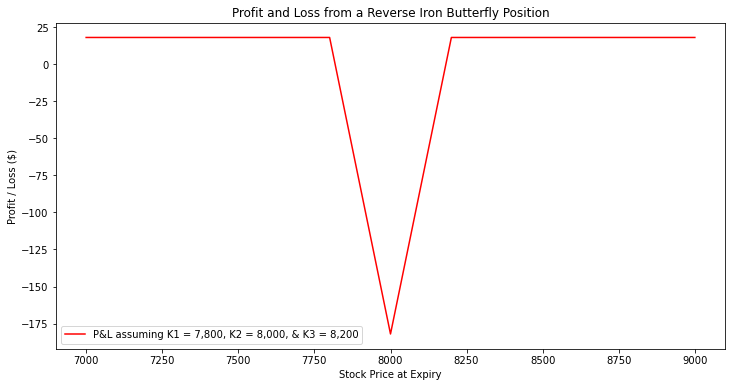

In [173]:
fig, ax = plt.subplots(figsize = (12,6))

ax.plot(sequence_stock_prices, Reverse_Butterfly_Spread_payoff + Reverse_Butterfly_Spread, color='red',
        label='P&L assuming K1 = 7,800, K2 = 8,000, & K3 = 8,200')
ax.set(title="Profit and Loss from a Reverse Iron Butterfly Position",
       xlabel='Stock Price at Expiry',
       ylabel='Profit / Loss ($)')
ax.legend()

plt.show()

As expected, assuming you set up this portfolio with strikes at 7800, 8000, and 8200, you should expect to receive a
profit so long as the final stock price falls **outside** these strike boundaries. Your net profit if this were to occur
is approximately $18.49$.

Remember that this portfolio benefits from an increase in volatility - essentially, a higher expectation of future price movement.

On the other hand, if the final stock price falls **within** these strike boundaries, you take on an increasingly large loss,
with the lowest loss of $(K_3 - K_2) - premium = 8200 - 8000 - 18.49 = 181.51$ being incurred if the stock price were to
remain unchanged from it's initial centre strike position (8000).


# Reflection

I have learnt the below from the feedbacks in the forum:
1. time_increment should be in years. I originally code it using number of months and my classmates recommended to use some other approach on this. I decided to change to a fraction of year as it is indicated somewhere that time_increment should be in years.
2. My refactoring of the option_price method initially caused the error statement to be printed each loop when the excercise option is not the predefined values(american & european). After reading the comments, I moved the print statement to the beginning of the statement so that the statement is only printed once.